In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal, integrate
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D, axes3d

# - for reloading libraries/modules - #
import importlib

import subroutines
import vis_eulag
importlib.reload(subroutines)

if os.path.exists('latex_default.mplstyle'):
    plt.style.use('latex_default.mplstyle')

# - Add Latex to PATH - #
# print(os.environ['PATH'])
# os.environ["PATH"] = '/Users/tennismichel/.gem/ruby/3.1.2/bin:/Users/tennismichel/.rubies/ruby-3.1.2/lib/ruby/gems/3.1.0/bin:/Users/tennismichel/.rubies/ruby-3.1.2/bin:/opt/homebrew/opt/proj@7/bin:/Users/tennismichel/LWD/snowpack/bin:/Users/tennismichel/LWD/meteoio/bin:/Users/tennismichel/opt/miniconda3/envs/3d_env/bin:/Users/tennismichel/opt/miniconda3/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin'

In [7]:
SETTINGS = vis_eulag.load_settings('settings_local_translb.txt')
fileLocations = ["/scratch/b/b309199/statlb_lid_cwind","/scratch/b/b309199/translb_lid_cwind", "/scratch/b/b309199/translb_lid_pnj"]
labels=['cwind_stat', 'cwind_trans', 'PNJ_trans']
ds_list = []
ds_lid_list = []

# --- Params --- #
t1 = 6
t2 = t1
# fig_folder = '../figures/'
fig_folder = '../figures_test/'
for fileLocation, lid_filename in zip(fileLocations,lid_filenames):
    # fileLocation = folder_path + fileLocation
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
    ds.attrs['cap'] = np.round(ds.attrs['cap'])
    ds.attrs['capp'] = np.round(ds.attrs['capp'])
    ds.attrs['compri'] = np.round(ds.attrs['compri'])
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    # ds['pprime']=ds['p'] # h12
    ds['pprime']=subroutines.filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?
  
    ds_cp = ds.copy()
    ds_list.append(ds_cp)
    
    lid_files_list = glob.glob(os.path.join(fileLocation, "lid_*"))
    print(lid_files_list)
    for lid_file in lid_files_list:
        ds_lid = xr.open_dataset(lid_file)
        ds_lid['time'] = ds_lid.t * ds.nlid * ds.dt00/3600
        ds_lid['time'] = ds_lid['time'].expand_dims({'z':ds_lid.z}, axis=1)
        ds_lid['zcr'] = ds_lid['zcr']/1000
        #ds_lid = vis_eulag.process_ds_lid(ds_lid, ds)
        ds_lid['location'] = lid_file.split("/")[-1][:-3]
        ds_lid_list.append(ds_lid)
    ds_lid = ds_lid_list[0]

    ds_lid = xr.open_dataset(os.path.join(fileLocation, lid_filename))
    ds_lid = vis_eulag.process_ds_lid(ds_lid, ds)
    ds_lid['location'] = lid_filename[:-3]
    ds_lid_list.append(ds_lid)
y=int(ds.ny/2) 

In [8]:
ds = ds_list[0]
ds

<xarray.Dataset>
Dimensions:    (t: 4, z: 301, y: 72, x: 1200)
Coordinates:
    xcr        (y, x) float32 0.0 12.5 25.0 ... 1.496e+04 1.498e+04 1.499e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -2.13e+03 -2.13e+03 ... 2.13e+03 2.13e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.372e+04 2.372e+04 ... 0.5273 0.5273
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 2.641e+04
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           6480
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         12500.0
    ...           ...
    grav:         9.80616
    cap:          0.0
    capi:         3.5
    capp:         1.0
    cappi:        1.4
    compri:       11.0

T:
[14.67, 12.08, 12.58, 12.0, 10.67, 10.33, 9.92, 12.58, 12.0, 10.67, 10.33, 9.92, 9.83, 12.0, 10.67]
Lambdax:
[732.86, 603.78, 628.76, 599.62, 532.99, 516.34, 495.52, 628.76, 599.62, 532.99, 516.34, 495.52, 491.35, 599.62, 532.99]
Lambdaz:
[8.25, 8.5, 8.5, 8.5, 8.5, 8.75, 8.75, 8.75, 8.75, 8.75, 8.75, 8.75, 8.75, 8.75, 8.75]
Phi:
[89.36, 89.19, 89.23, 89.19, 89.09, 89.03, 88.99, 89.2, 89.16, 89.06, 89.03, 88.99, 88.98, 89.16, 89.06]
cpx:
[26.26, 27.05, 27.05, 27.05, 27.05, 27.85, 27.85, 27.85, 27.85, 27.85, 27.85, 27.85, 27.85, 27.85, 27.85]
lambdaz:  8.75
T:  10.666666666666671
lambdax:  532.9920000000002
lambdax2:  462.204
lambdax from xz-plot: 525
lambdax2 from xz-plot: 712


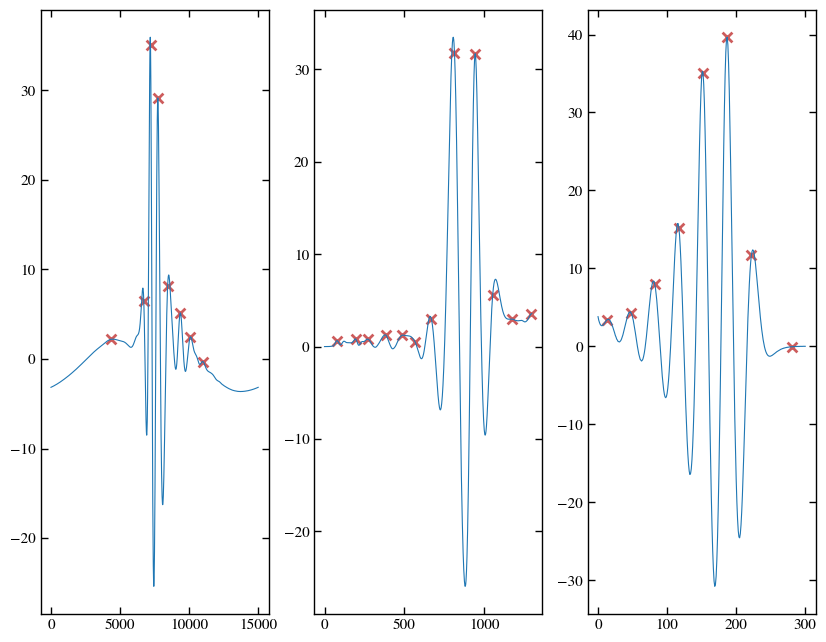

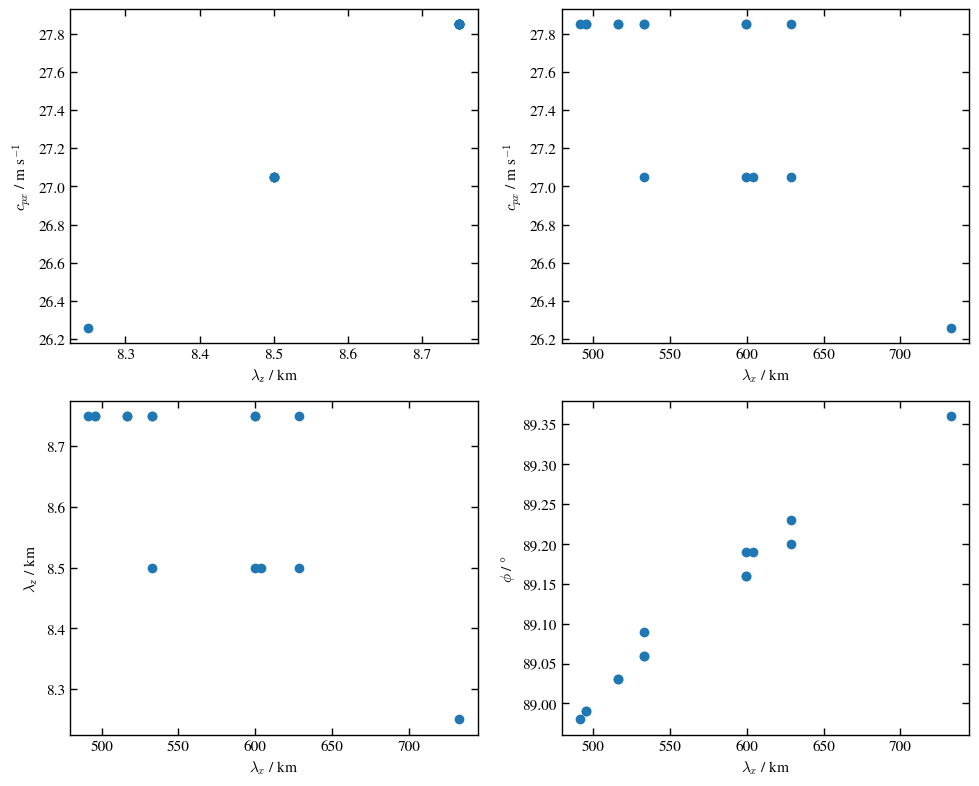

In [4]:
# --- Analysis of vertical time series --- #
# --- T, lambda_z, c_pz, c_gz, --- #
def arg_find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

i_sim = 1
ds = ds_list[i_sim].copy()
ds_lid = ds_lid_list[i_sim].copy()

var = 'th'
z = np.linspace(0,ds_lid['zcr'][0,-1].values,int(ds.nz)) # ds['dx']=200
UNDEF=np.nan
data_i=ds_lid[var].copy()
for ix in range(0,np.shape(data_i)[0]):
    data_i[ix,:] = np.interp(z,ds_lid['zcr'][ix,:],ds_lid[var][ix,:],left=UNDEF)
ds_lid[var] = data_i
    
zanas = [32,34,36,38,40] # km
tanas = [68,72,76] # h
xana = 7500
zi_ana_xz = 160 # 40 km not interp grid

vlambdax = []
vlambdaz = []
vphi = []
vT = []
vcpx = []
vcpz = []
for tana in tanas:
    for zana in zanas:
        # -- Define t and z planes -- #
        # tana  = 78 # h
        # zana  = 35 # km
        tiana = int(tana*3600 / (ds.nlid*ds.dt00))
        ziana = int(zana / (ds.dz00/1000))
        xiana = int(xana / (ds.dx00/1000))

        # -- Calculate local maxima and corresponding lambda_z and T (period) -- #
        widths = np.arange(1,100)
        widths = np.arange(4,30)
        # lmax_iz = signal.find_peaks_cwt(ds_lid['w_aeq'][:],np.arange(4,30)) # min_snr=1
        lmax_iz = signal.find_peaks_cwt(ds_lid[var][tiana,:],widths) # min_snr=1
        lmax_it = signal.find_peaks_cwt(ds_lid[var][:,ziana],widths)

        lmax_ix = signal.find_peaks_cwt(ds['th'][t1,zi_ana_xz,y,:],np.arange(1,100))
        #  = signal.find_peaks(ds['th'][t1,zi_ana_xz,y,:])

        # - Take the wavelength closest/below the PNJ - #
        # imax = np.argmax(ds_lid['w'][tiana,lmax_iz])
        iiz = arg_find_nearest(lmax_iz,ziana)
        iit = arg_find_nearest(lmax_it,tiana)
        iix = arg_find_nearest(lmax_ix,xiana)

        # - Makes sure to always be around the values - #
        if (lmax_iz[iiz] < ziana):
            lmax_iz0 = lmax_iz[iiz]
            lmax_iz1 = lmax_iz[iiz+1]
        else:
            lmax_iz0 = lmax_iz[iiz-1]
            lmax_iz1 = lmax_iz[iiz]

        if (lmax_it[iit] < tiana):
            lmax_it0 = lmax_it[iit]
            lmax_it1 = lmax_it[iit+1]
            lmax_it2 = lmax_it[iit+2]
        else:
            lmax_it0 = lmax_it[iit-1]
            lmax_it1 = lmax_it[iit]
            lmax_it2 = lmax_it[iit+1]

        if (lmax_ix[iix] < xiana):
            lmax_ix0 = lmax_ix[iix]
            lmax_ix1 = lmax_ix[iix+1]
            lmax_ix2 = lmax_ix[iix+2]
        else:
            lmax_ix0 = lmax_ix[iix-1]
            lmax_ix1 = lmax_ix[iix]
            lmax_ix2 = lmax_ix[iix+1]

        N       = ds.bv

        # -- Assume stationary wave field -- #
        lambdaz = (z[lmax_iz1]-z[lmax_iz0])*1000
        m       = 2*np.pi/lambdaz
        T       = (ds_lid['time'][lmax_it1,0].values - ds_lid['time'][lmax_it0,0].values) * 3600
        ctopo   = 13.88
        lambdax = ctopo * T
        k       = 2*np.pi/lambdax
        phi     = np.arctan(lambdax/lambdaz)
        cpz     = N/m * np.cos(phi)
        cpx     = N/k * np.cos(phi)
        # cpx     = N/m * np.sin(phi)
        # cgx, cgz
        # -- Assume stationary wave field -- #


        # -- not applicable -- #
        # omega   = (lmax_it1-lmax_it0)*(ds.dt00*ds.nlid)
        # cpz     = lambdaz/omega
        # phi     = np.arccos(m/ds.bv*cpz)
        # k       = m / np.sqrt((ds.bv/omega)**2-1)
        # k       = m / np.sqrt(1-(ds.bv/omega)**2)
        # k       = m / np.tan(phi)
        # lambdax = 2*np.pi/k
        # -- not applicable -- #
        
        vT.append(round(T/3600,2))
        vlambdaz.append(round(lambdaz/1000,2))
        vlambdax.append(round(lambdax/1000,2))
        vphi.append(round(phi*180/np.pi,2))
        vcpz.append(round(cpz,2))
        vcpx.append(round(cpx,2))
        """
        print("T: {:0.2f}h".format(T/3600))
        print("Lambda_z: {:0.2f}m".format(lambdaz))
        print("Lambda_x: {:0.2f}m".format(lambdax))
        print("phi: {:0.2f}".format(phi))
        print("cp_z: {:0.2f}m/s".format(cpz))
        print("cp_x: {:0.2f}m/s".format(cpx))
        print("U-ctopo: {:0.2f}m/s".format(ds.u00-ctopo))
        """
print('T:')
print(vT)
print('Lambdax:')
print(vlambdax)
print('Lambdaz:')
print(vlambdaz)
print('Phi:')
print(vphi)
print('cpx:')
print(vcpx)

# - Last one - #
lambdaz = (z[lmax_iz1]-z[lmax_iz0])*1000
m       = 2*np.pi/lambdaz
T       = (ds_lid['time'][lmax_it1,0].values - ds_lid['time'][lmax_it0,0].values) * 3600
T2       = (ds_lid['time'][lmax_it2,0].values - ds_lid['time'][lmax_it1,0].values) * 3600
ctopo   = 13.88
lambdax = ctopo * T
lambdax2 = ctopo * T2
lambdax_from_xz = (ds['xcr'][y,lmax_ix1]-ds['xcr'][y,lmax_ix0])
lambdax_from_xz2 = (ds['xcr'][y,lmax_ix2]-ds['xcr'][y,lmax_ix1])

print('lambdaz: ', z[lmax_iz1]-z[lmax_iz0])
print('T: ', T/ 3600 )
print('lambdax: ', lambdax / 1000 )
print('lambdax2: ', lambdax2 / 1000 )
print('lambdax from xz-plot: ' + str(int(lambdax_from_xz)))
print('lambdax2 from xz-plot: ' + str(int(lambdax_from_xz2)))

fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(10,8))
ax0.plot(ds['xcr'][y,:], ds['th'][t1,zi_ana_xz,y,:])
ax0.scatter(ds['xcr'][y,lmax_ix], ds['th'][t2,zi_ana_xz,y,lmax_ix],marker='x',color='indianred',s=50, linewidths=2)
# ax0.scatter(lmax_iz[iiz], ds_lid['w'][tiana,lmax_iz[iiz]],marker='x',color='green',s=50, linewidths=2)
ax1.plot(ds_lid['th'][:,ziana])
ax1.scatter(lmax_it, ds_lid['th'][lmax_it,ziana],marker='x',color='indianred',s=50, linewidths=2)
ax2.plot(ds_lid['th'][tiana,:])
ax2.scatter(lmax_iz, ds_lid['th'][tiana,lmax_iz],marker='x',color='indianred',s=50, linewidths=2)

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(10,8))
ax0.scatter(vlambdaz, vcpx)
ax0.set_ylabel('$c_{px}$ / m s$^{-1}$')
ax0.set_xlabel('$\lambda_z$ / km')

ax1.scatter(vlambdax, vcpx)
ax1.set_ylabel('$c_{px}$ / m s$^{-1}$')
ax1.set_xlabel('$\lambda_x$ / km')

ax2.scatter(vlambdax, vlambdaz)
ax2.set_ylabel('$\lambda_z$ / km')
ax2.set_xlabel('$\lambda_x$ / km')

ax3.scatter(vlambdax, vphi)
ax3.set_ylabel('$\phi$ / °')
ax3.set_xlabel('$\lambda_x$ / km')

fig.tight_layout()
fig_title = 'lid_ana.png'
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=150)

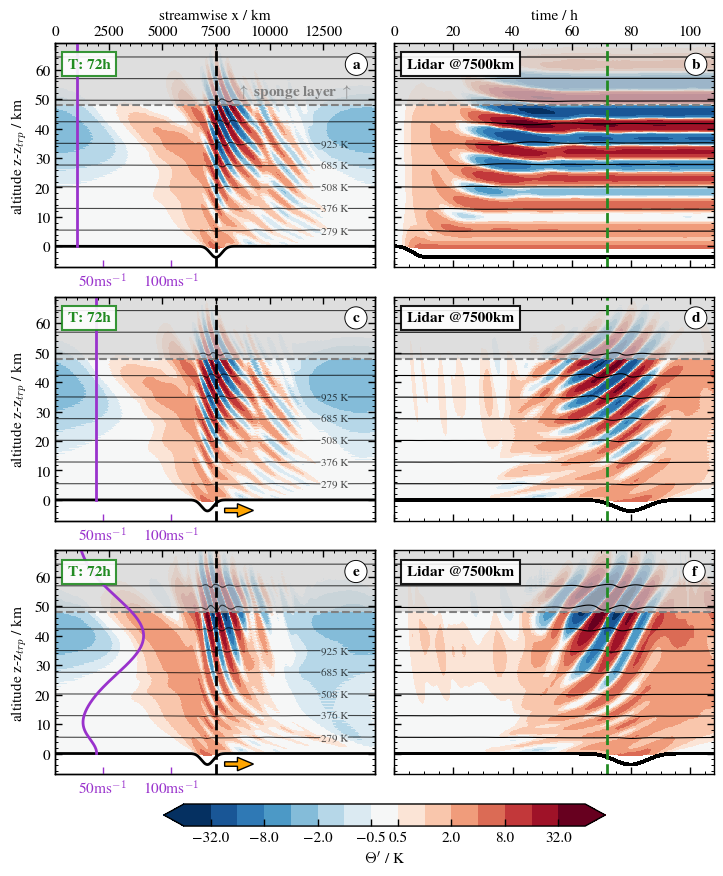

In [14]:
# --- Theta --- #
gskw = {'hspace':0.17, 'wspace':0.06, 'height_ratios': [7,7,7,1]} #  , 'width_ratios': [5,5]}
# gskw = {'hspace':0.2}
fig, axes = plt.subplots(4,2,figsize=(8.5,10.5),sharey=True, gridspec_kw=gskw)
# fig, axes = plt.subplots(3,2,figsize=(9,10),sharey=True)
axes[3,0].set_axis_off()
axes[3,1].set_axis_off()

# - PARAMS - #
cmap = plt.get_cmap('RdBu_r')
clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

zl = -7
zu = 69
ZLIM = [zl,zu]
XLIM = [0,14900]  # 1000km
XLIM_LID = [0,108]
# XLIM_LID = [66,78]
c1 = 'black'
c2 = 'forestgreen'
c3 = 'lightgrey'
c4 = 'darkorchid'
lw_1 = 2
lw_2 = 1.5
lw_sponge = 1.5
xp = 0.04
yp = 0.89
alpha_box = 0.9
alpha_sponge = 0.67
show_lid = True
show_ana = False

# numb_str = ['A','B','C','D','E','F']
numb_str = ['a','b','c','d','e','f']

for i in range(3):
    t=t1
    ds = ds_list[i]
    ds_lid = ds_lid_list[i]

    ax0 = axes[i,0]
    ax1 = axes[i,1]
    
    ax0.grid(False)
    ax1.grid(False)
    pcMesh0 = ax0.pcolormesh(ds.xcr[y], ds.zcr[t,:,y,:], ds.th[t,:,y,:],
                            cmap=cmap, norm=norm, shading='nearest')
    ax0 = subroutines.format_xz_plot(ds, SETTINGS, ax0, t, y=y)

    # if show_lid and i==0:
    if show_lid:
        pcMesh1 = ax1.pcolormesh(ds_lid.time, ds_lid.zcr, ds_lid.th,
                                cmap=cmap, norm=norm, shading='nearest')
        
        ax1 = subroutines.format_tz_plot(ds_lid, ds, SETTINGS, ax1)

    # - YLABELS LEFT - #
    ax0.set_ylabel('altitude z-z$_{trp}$ / km')
    # fig.canvas.draw()
    # height_tick = ax0.get_yticks()
    # height_tick_labels = ax0.get_yticklabels()
    # height_tick_labels[1] = r"0 (z$_{trp}$)"
    # ax0.set_yticks(height_tick)
    # ax0.set_yticklabels(height_tick_labels)
    
    ax0.set_ylim(ZLIM)
    ax0.set_xlim(XLIM)
    
    # - TIME LIMIT FOR LIDAR PLOT - #
    ax1.set_xlim(XLIM_LID)

    # --- Ticks --- #
    ax0.yaxis.set_minor_locator(AutoMinorLocator()) 
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax0.tick_params(labelbottom=False,labeltop=False)
    ax1.tick_params(labelbottom=False,labeltop=False)

    # - Sponge layer - #
    ax0.axhline(y=48, lw=lw_2,ls='--',color='grey')
    ax1.axhline(y=48, lw=lw_2,ls='--',color='grey')
    ax0.fill_between(XLIM, [zu,zu], [48,48], facecolor=c3, alpha=alpha_sponge)
    ax1.fill_between(XLIM_LID, [zu,zu], [48,48], facecolor=c3, alpha=alpha_sponge)

    # ax0.axvline(x=xloc1, color='olivedrab', lw=3, ls='--')
    xloc = int(str(ds_lid['location'].values)[6:9]) * ds.dx00/1000
    yloc = (int(str(ds_lid['location'].values)[-3:]) - int(ds.ny/2)) * ds.dy00/1000
    tloc = t1*12
    ax0.vlines(x=[xloc], ymin=zl,ymax=zu, colors=c1, lw=lw_1, ls='--')
    ax1.vlines(x=[tloc], ymin=zl,ymax=zu, colors=c2, lw=lw_1, ls='--')

    # - Wind axis - #
    ax_wind = ax0.twiny()
    x=0
    ax_wind.plot(ds['ue'][t,:,y,x], ds.zcr[t,:,y,x], lw=2, ls='-', color=c4, label='$u_e$')
    # ax_wind.set_xlabel('$\hat{u}$ / m s$^{-1}$')
    ax_wind.set_xlim([15,250])
    # ax_wind.xaxis.set_minor_locator(AutoMinorLocator())
    ax_wind.tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=True,labeltop=False)
    wind_xticks = ax_wind.get_xticks()
    plt.xticks(wind_xticks[1:3], labels=['50ms$^{-1}$', '100ms$^{-1}$'], fontweight='normal', visible=True)
    ax_wind.tick_params(axis="x", top=False, bottom=True, labelbottom=True,labeltop=False)
    ax_wind.xaxis.label.set_color(c4)
    ax_wind.tick_params(axis='x', colors=c4)
    # direction="out", pad=-20
    
    # - Text - #
    tstr = 'T: ' + str(12*t1) + 'h'
    lidstr = 'Lidar @' + str(int(xloc)) + 'km'
    tt1=ax_wind.text(xp, yp, tstr, transform=ax_wind.transAxes, weight='bold', color=c2,backgroundcolor='1')
    tt2=ax1.text(xp, yp, lidstr, transform=ax1.transAxes, weight='bold', color=c1,backgroundcolor='1')
    tt1.set_bbox(dict(facecolor='white', alpha=alpha_box,edgecolor=c2,lw=lw_2))
    tt2.set_bbox(dict(facecolor='white', alpha=alpha_box,edgecolor=c1,lw=lw_2))

    # - Numbering - #
    xpp = 0.93
    ypp = 0.89
    ax0.text(xpp, ypp, numb_str[2*i], transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    ax1.text(xpp, ypp, numb_str[2*i+1], transform=ax1.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

    # - Arrows - #
    if i > 0:
        ax0.arrow(0.53, 0.045, 0.04, 0, width = 0.02, head_length=0.05, transform=ax0.transAxes,  facecolor='orange', edgecolor='black')

    ax0.tick_params(which='both', top=True, right=True, bottom=False)
    # ax0.set_zorder(10)
    # ax0.patch.set_visible(False)

# --- Formatting --- #
axes[0,0].set_xlabel('streamwise x / km') # change to longitudes, latitude 10$^3$
axes[0,1].set_xlabel('time / h') # change to longitudes, latitude
axes[0,0].xaxis.set_label_position('top') 
axes[0,1].xaxis.set_label_position('top')

axes[0,0].tick_params(which='both', top=True, labelbottom=False,labeltop=True)
axes[0,1].tick_params(labelbottom=False,labeltop=True)

# - Sponge text - #
sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
axes[0,0].text(0.57, 0.77, sponge_label, transform=axes[0,0].transAxes, weight='bold', color='grey')

# --- Include wavelength and omega analysis for second lidar positon --- #
c5 = 'orchid'
c6 = 'limegreen'
s1 = 60
if show_ana:
    axes[i_sim,1].vlines(x=[tana], ymin=z[lmax_iz0],ymax=z[lmax_iz1], colors=c5, lw=lw_1, ls='-')
    axes[i_sim,1].hlines(y=[zana], xmin=ds_lid['time'][lmax_it0,ziana],xmax=ds_lid['time'][lmax_it1,ziana], colors=c6, lw=lw_1, ls='-')
    axes[i_sim,1].scatter(ds_lid['time'][lmax_it0,ziana], zana, color='black', s=s1, marker='x')
    axes[i_sim,1].scatter(ds_lid['time'][lmax_it1,ziana], zana, color='black', s=s1, marker='x')
    axes[i_sim,1].scatter(ds_lid['time'][tiana,lmax_iz0], z[lmax_iz0], color='black', s=s1, marker='x')
    axes[i_sim,1].scatter(ds_lid['time'][tiana,lmax_iz1], z[lmax_iz1], color='black', s=s1, marker='x')
    tt01 = axes[i_sim,1].text(0.75, 0.7, r"$\bf{\lambda_z}$", transform=axes[i_sim,1].transAxes, color=c5)
    tt02 = axes[i_sim,1].text(0.55, 0.63, r'$T$', transform=axes[i_sim,1].transAxes, color=c6)
    tt01.set_bbox(dict(facecolor='white', alpha=alpha_box,edgecolor=c5,lw=lw_2))
    tt02.set_bbox(dict(facecolor='white', alpha=alpha_box,edgecolor=c6,lw=lw_2))

    # - XZ plot - #
    axes[i_sim,0].hlines(y=[zana], xmin=ds['xcr'][y,lmax_ix0],xmax=ds['xcr'][y,lmax_ix1], colors=c6, lw=lw_1, ls='-')
    axes[i_sim,0].hlines(y=[zana], xmin=ds['xcr'][y,lmax_ix1],xmax=ds['xcr'][y,lmax_ix2], colors='goldenrod', lw=lw_1, ls='-')
    axes[i_sim,0].scatter(ds['xcr'][y,lmax_ix0], zana, color='black', s=s1, marker='x')
    axes[i_sim,0].scatter(ds['xcr'][y,lmax_ix1], zana, color='black', s=s1, marker='x')
    axes[i_sim,0].scatter(ds['xcr'][y,lmax_ix2], zana, color='black', s=s1, marker='x')
    tt01 = axes[i_sim,0].text(0.37, 0.63, r"$\bf{\lambda_x}$", transform=axes[i_sim,0].transAxes, color=c6)
    tt01.set_bbox(dict(facecolor='white', alpha=alpha_box,edgecolor=c6,lw=lw_2))

# - Cbar - #
cbar = fig.colorbar(pcMesh1, ax=axes[3,:], location='bottom', shrink=0.67, fraction=1, ticks=clev_l, pad=0, extend='both') #  pad=0.15 default
cbar.set_label(r"$\Theta'$ / K")

# --- Save figure --- #
# fig.suptitle(title_label)
# fig_title = 'lidana_th.png'
fig_title = 'lidana_th_empty0.png'
# fig.tight_layout()
fig_folder = '../figures_test/'
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=450, bbox_inches='tight')
# fig_title = 'lidana_th.svg'
# fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
#                 format='svg',dpi=300)